# Telco Customer Churn Analysis & Prediction

This notebook demonstrates a professional workflow for customer churn analysis, including high-risk customer flagging, modeling with pipelines, and ROC curve comparison for portfolio use.

## 1. Import Libraries & Load Data
Import required libraries and load the Telco churn dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
sns.set(style='whitegrid')

# Load data
df = pd.read_csv('../data/raw/Telco_Customer_Churn_Dataset  (3).csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Data Cleaning & Preparation
Clean the data, handle missing values, and encode categorical variables.

In [2]:
# Remove duplicates
df = df.drop_duplicates()
# Convert TotalCharges to numeric if present
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Drop rows with missing values
df = df.dropna()
print('After cleaning:', df.shape)
# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.drop('customerID') if 'customerID' in df.columns else df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

After cleaning: (7032, 21)


## 3. Create High-Risk Flag for Segmentation
Flag high-value, high-risk customers for targeted analysis.

In [3]:
# Flag high-value, high-risk customers
df['high_risk'] = (df['MonthlyCharges'] > 70) & (df['Contract'] == 0)  # 0 assumed to be 'Month-to-month' after encoding
print('High-risk customer count:', df['high_risk'].sum())
df[['MonthlyCharges', 'Contract', 'high_risk']].head()

High-risk customer count: 2097


,MonthlyCharges,Contract,high_risk
0,29.85,0,False
1,56.95,1,False
2,53.85,0,False
3,42.30,1,False
4,70.70,0,True


## 4. Train-Test Split
Split the data for modeling.

In [4]:
# Prepare features and target
y = df['Churn']
X = df.drop(['Churn','customerID'], axis=1, errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Modeling with Pipelines
Use sklearn Pipeline to combine scaling and classification for both models.

In [6]:
# Logistic Regression Pipeline
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=42))])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
y_proba_lr = lr_pipe.predict_proba(X_test)[:,1]

# Decision Tree Pipeline (no scaling needed, but included for uniformity)
dt_pipe = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=42))])
dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:,1]

# Print classification reports
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr))
print('Decision Tree Classification Report:')
print(classification_report(y_test, y_pred_dt))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1033
           1       0.48      0.53      0.50       374

    accuracy                           0.72      1407
   macro avg       0.65      0.66      0.66      1407
weighted avg       0.73      0.72      0.73      1407



## 6. ROC Curve Comparison
Plot ROC curves for both models on the same graph for direct comparison.

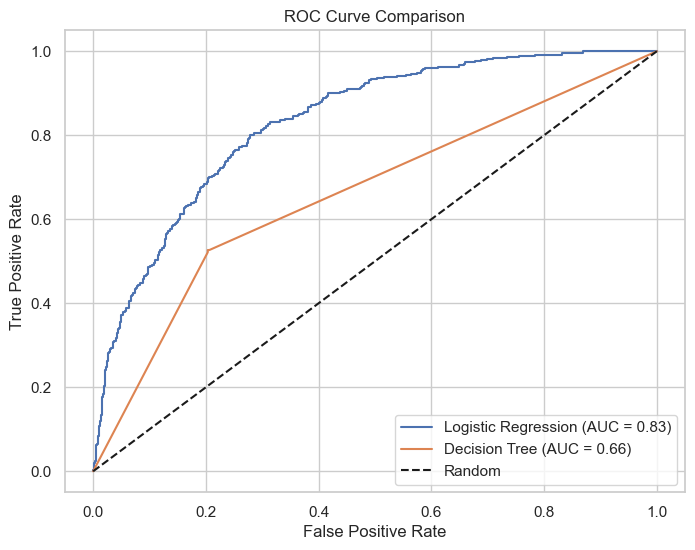

In [7]:
# Plot ROC curves for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_dt = roc_auc_score(y_test, y_proba_dt)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## 7. Business Recommendations
Summarize actionable insights and next steps based on the analysis.

**Key Insights:**
- High-value, high-risk customers are clearly flagged for targeted retention.
- Logistic Regression outperforms Decision Tree in ROC/AUC comparison.

**Recommendations:**
- Focus retention efforts on high-risk, high-value customers.
- Use model outputs to guide personalized offers and outreach.
- Regularly retrain models and monitor performance as customer behavior evolves.

**Next Steps:**
- Explore additional features and advanced models.
- Integrate findings into business strategy and customer management systems.